In [2]:
import pandas as pd
import yfinance as yf
import numpy as np

from hurst import compute_Hc

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [3]:
index = ["^DJI", "^FTSE", "^FTMC", "^FTAI", "^N225", "^STOXX50E"]

In [4]:
data = yf.download(index,start='2021-01-01')

[*********************100%***********************]  6 of 6 completed


In [5]:
data = data['Adj Close']

In [6]:
print(data.isnull().sum())

^DJI         21
^FTAI        36
^FTMC        22
^FTSE        22
^N225        38
^STOXX50E    17
dtype: int64


In [7]:
data.fillna(method='ffill', inplace=True)

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data['^FTAI'])

Date
2021-01-04            NaN
2021-01-05    1168.369995
2021-01-06    1172.469971
2021-01-07    1174.540039
2021-01-08    1179.760010
2021-01-11    1178.760010
2021-01-12    1179.030029
2021-01-13    1185.560059
2021-01-14    1183.619995
2021-01-15    1173.119995
2021-01-18    1174.270020
2021-01-19    1181.130005
2021-01-20    1187.500000
2021-01-21    1198.089966
2021-01-22    1198.089966
2021-01-25    1198.560059
2021-01-26    1198.410034
2021-01-27    1176.150024
2021-01-28    1176.150024
2021-01-29    1160.670044
2021-02-01    1170.969971
2021-02-02    1188.959961
2021-02-03    1198.949951
2021-02-04    1204.069946
2021-02-05    1211.579956
2021-02-08    1210.599976
2021-02-09    1211.819946
2021-02-10    1211.510010
2021-02-11    1218.800049
2021-02-12    1219.849976
2021-02-15    1219.849976
2021-02-16    1228.260010
2021-02-17    1228.260010
2021-02-18    1205.880005
2021-02-19    1214.180054
2021-02-22    1200.630005
2021-02-23    1183.880005
2021-02-24    1188.260010
2021-02

In [9]:
data = data.asfreq('W', method='ffill')

In [10]:
data

^DJI        ^FTAI         ^FTMC        ^FTSE  \
Date                                                               
2021-01-10  31097.970703  1179.760010  21064.199219  6873.299805   
2021-01-17  30814.259766  1173.119995  20615.599609  6735.700195   
2021-01-24  30996.980469  1198.089966  20596.900391  6695.100098   
2021-01-31  29982.619141  1160.670044  20228.599609  6407.500000   
2021-02-07  31148.240234  1211.579956  21066.900391  6489.299805   
...                  ...          ...           ...          ...   
2023-05-07  33674.378906   828.789978  19452.500000  7778.399902   
2023-05-14  33300.621094   816.960022  19188.400391  7754.600098   
2023-05-21  33426.628906   808.969971  19289.099609  7756.899902   
2023-05-28  33093.339844   791.710022  18794.099609  7627.200195   
2023-06-04  33762.761719   789.580017  19149.300781  7607.299805   

                   ^N225    ^STOXX50E  
Date                                   
2021-01-10  28139.029297  3645.050049  
2021-01-17  28519.179688  3599.550049  
2021-01-24  28631.449219  3602.409912  
2021-01-31  27663.390625  3481.439941  
2021-02-07  28779.189453  3655.770020  
...                  ...          ...  
2023-05-07  29157.949219  4340.430176  
2023-05-14  29388.300781  4317.879883  
2023-05-21  30808.349609  4395.299805  
2023-05-28  30916.310547  4337.500000  
2023-06-04  31524.220703  4323.520020  

[126 rows x 6 columns]

In [11]:
def get_ts_mom_strategy_returns(data, lookback, hold, freq):
    df = pd.DataFrame()
    data = data.asfreq(freq, method='ffill')
    df['lookback_returns'] = data.pct_change(lookback)
    df['Hold period returns'] = data.pct_change(hold).shift(-hold)
    df = df.dropna()
    
    df['positions'] = np.where(df['lookback_returns'] > 0, 1, -1)
    
    df['strategy_returns'] = df['Hold period returns'] * df['positions']
    return df['strategy_returns']

In [12]:
def analytics_returns(data_strategy_returns, title_name):
    
    
    sharpe = (np.mean(data_strategy_returns) /
        np.std(data_strategy_returns)*(12**0.5))
    
    sharpe.plot.bar(figsize=(10, 7), color='blue')
    plt.ylabel('Sharpe')
    plt.title(title_name)
    plt.show()

    # Calculate the cumulative strategy returns
    
    cum_rets = (data_strategy_returns/100 + 1).cumprod()
    
    cum_rets.plot(figsize=(10, 7))

    # Set title and labels for the plot
    plt.title(title_name, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.show()

    total_months = len(cum_rets)
    analytics = pd.DataFrame()

    # Calculate annalised returns
    analytics['Annualised Returns'] = (cum_rets.iloc[-2]**(12/total_months)-1)*100

    # Calculate annualised volatility
    analytics['Annualised Volatility'] = np.std(data_strategy_returns)*(12**0.5)

    # Calculate maximum drawdown
    def calc_drawdown(cum_rets):

        # Calculate the running maximum
        running_max = np.maximum.accumulate(cum_rets.dropna())

        # Ensure the value never drops below 1
        running_max[running_max < 1] = 1

        # Calculate the percentage drawdown
        drawdown = (cum_rets)/running_max - 1
        return drawdown

    analytics['Max Drawdown'] = cum_rets.apply(calc_drawdown, axis=0).min()*100

    print(analytics)

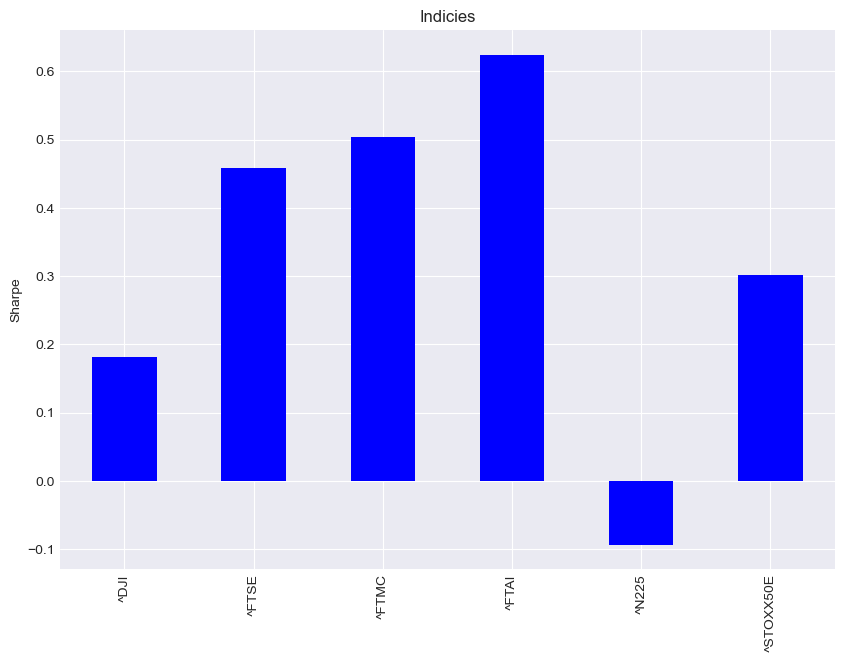

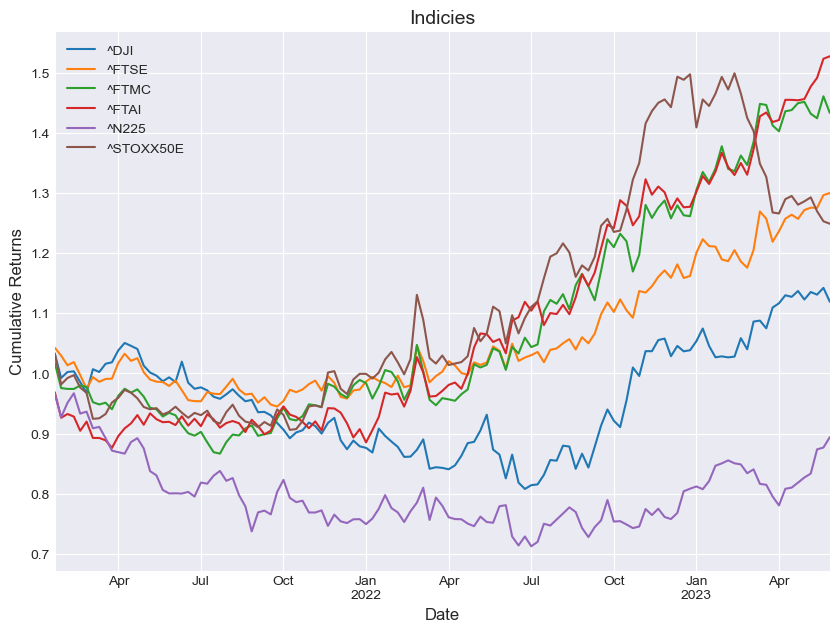

           Annualised Returns  Annualised Volatility  Max Drawdown
^DJI                 1.308893               7.698241    -23.123157
^FTSE                2.569217               5.993248     -9.389588
^FTMC                3.771042               7.546130    -14.866188
^FTAI                4.195706               7.027899    -12.383810
^N225               -1.275269               8.134880    -28.763176
^STOXX50E            2.227430               8.351080    -16.696601


In [13]:
data_strategy_returns = data[index].apply(
    get_ts_mom_strategy_returns, lookback=2, hold=1, freq='w', axis=0)*100

analytics_returns(data_strategy_returns, 'Indicies')

In [14]:
def get_hurst(data):
    hurst_value = compute_Hc(data.dropna(), kind='price', simplified=False)[0]
    return hurst_value

In [15]:
def hurst_plot(hurst_plot_graph, title_name):
    plt.subplots(figsize=(10,7))
    hurst_plot_graph = ['grey' if (x < 0.65) else 'green' for x in hurst.values]
    seaborn.barplot(x=hurst.index, y=hurst.values, palette=hurst_plot_graph)

    # Set style for the bar graph
    plt.axhline(0.65, color="red")
    plt.title(title_name, fontsize=14)
    plt.ylabel('Hurst Values', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

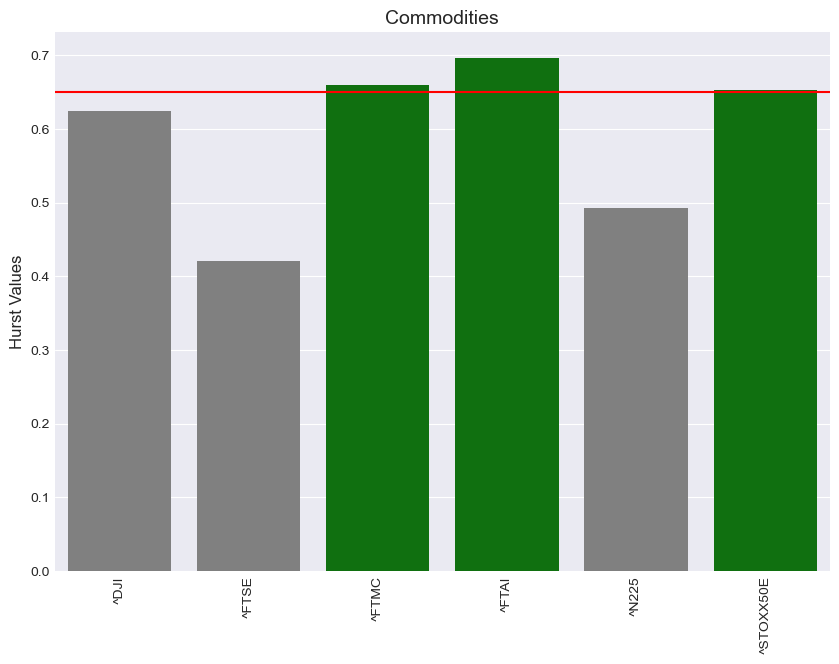

In [16]:

hurst = data[index].apply(get_hurst)


hurst_plot(hurst.sort_values(0), 'Commodities')

In [17]:
print(hurst)

^DJI         0.623994
^FTSE        0.421150
^FTMC        0.659193
^FTAI        0.696576
^N225        0.493351
^STOXX50E    0.653111
dtype: float64
